In [176]:
import numpy as np
import pandas as pd
import os
from scipy.stats import loguniform

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils._testing import ignore_warnings 
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning 

from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import statistics
import math
import seaborn as sns

In [90]:
%store -r wp4
wp4 = wp4
 
%store -r wp8
wp8 = wp8

%store -r dwt4
dwt4 = dwt4

%store -r dwt8
dwt8 = dwt8

## 1. Fisher's

In [ ]:
def fishers(df, top_n=5): #default 5 windows with highest Fisher's criterion values

    col_names = df.columns 
    df_long = pd.melt(df, id_vars=['state'], value_vars=col_names)
    df_mean = df_long.groupby(['state', 'variable'], as_index=False).mean() #mean for each window, grouped by state (0 or 1)
    df_stdev = df_long.groupby(['state', 'variable'], as_index=False).std() #stdev for each window, grouped by state (0 or 1)

    df_summary = pd.merge(df_mean, df_stdev, how='inner', on=['state', 'variable']) #join mean and stdev
    df_summary.columns = ['state', 'slope', 'mean', 'stdev'] #rename columns

    df_summary = pd.pivot(df_summary, columns='state', index='slope', values=['mean', 'stdev']) #pivot wider on state
    df_summary.columns = ['mean_0', 'mean_1', 'stdev_0', 'stdev_1'] #0 for controls, 1 for cases
    df_summary['fishers'] = (df_summary['mean_1'] - df_summary['mean_0'])**2 / (df_summary['stdev_1']**2 + df_summary['stdev_0']**2) #calculate Fisher's criterion for each window
    df_summary = df_summary.sort_values(by='fishers', ascending=False)
    df_summary.reset_index(inplace=True)

    sel_windows = df_summary.head(n=top_n)['slope'].to_list() #list of n windows with highest Fisher's criterion values, default = 5
    sel_windows.append('state') #add 'state' to list
    df = df[sel_windows] #subset original dataframe with n windows with highest Fisher's criterion values + state

    return df


## 2.1 Logistic Regression (default parameters)

In [88]:
def log_reg(df, n_iter=1000):

    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()    
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        log_reg_model = LogisticRegression(class_weight='balanced') #default 
        log_reg_model.fit(x_train, y_train.values.ravel())
        
        y_pred = log_reg_model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [96]:
log_reg(wp8, n_iter=1000).head()

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy
0,0.966667,0.935484,0.950820,31,0.962963,0.981132,0.971963,53,0.964286
1,0.968750,0.911765,0.939394,34,0.942308,0.980000,0.960784,50,0.952381
2,0.909091,0.967742,0.937500,31,0.980392,0.943396,0.961538,53,0.952381
3,0.961538,0.961538,0.961538,26,0.982759,0.982759,0.982759,58,0.976190
4,0.937500,0.967742,0.952381,31,0.980769,0.962264,0.971429,53,0.964286


In [94]:
round(log_reg(wp8, n_iter=1000)['accuracy'].mean(), 3)

0.961

In [95]:
round(log_reg(dwt8, n_iter=1000)['accuracy'].mean(), 3)

0.956

## 2.2 Logistic Regression (random search)

In [180]:
@ignore_warnings(category=(ConvergenceWarning, FitFailedWarning)) #ignore warnings for forbidden parameter combinations between solvers and penalty in grid

def log_reg_random_search(df, n_iter = 100): 

    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()
        log_reg_model = LogisticRegression(class_weight='balanced')
        param_grid = {
            'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
            'log_reg__C': loguniform(1e-5, 100)
        }
        
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3) 
        pipeline = Pipeline(steps=[("scaler", scaler), ("log_reg", log_reg_model)])
        search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv)
        
        result = search.fit(x_train, y_train.values.ravel())
        y_pred = result.predict(x_test)
        
        report = classification_report(y_test, y_pred, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [181]:
log_reg_random_search(wp8, n_iter=5)

/Users/jhbyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan 0.9502451  0.8497549         nan        nan 0.93480392
        nan        nan 0.9502451  0.93284314 0.85980392 0.94656863
        nan 0.90661765 0.89522059        nan        nan        nan
 0.35735294 0.9502451         nan 0.83995098 0.93443627        nan
 0.94852941 0.92892157        nan        nan        nan 0.92855392
        nan 0.94436275 0.94436275 0.925             nan        nan
 0.92892157 0.94044118 0.35735294        nan        nan 0.94852941
 0.94852941        nan        nan        nan 0.925             nan
        nan 0.9504902         nan 0.92892157        nan        nan
        nan 0.94656863        nan        nan        nan 0.35735294
 0.95036765 0.93823529        nan        nan        nan        nan
 0.9502451         nan        nan        nan 0.35735294 0.35735294
        nan        nan        nan     

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy
0,0.937500,0.967742,0.952381,31,0.980769,0.962264,0.971429,53,0.964286
1,1.000000,0.941176,0.969697,34,0.961538,1.000000,0.980392,50,0.976190
2,0.968750,0.968750,0.968750,32,0.980769,0.980769,0.980769,52,0.976190
3,0.851852,0.958333,0.901961,24,0.982456,0.933333,0.957265,60,0.940476
4,1.000000,0.925926,0.961538,27,0.966102,1.000000,0.982759,57,0.976190


In [182]:
round(log_reg_random_search(wp8, n_iter=5)['accuracy'].mean(), 3)

/Users/jhbyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.92071078 0.92071078        nan 0.85698529 0.93431373        nan
 0.86691176 0.96446078 0.95453431        nan        nan 0.92071078
 0.9625     0.95845588        nan 0.38088235        nan        nan
        nan 0.96838235        nan 0.96446078        nan        nan
        nan 0.95257353        nan 0.38088235        nan 0.92267157
        nan        nan        nan        nan 0.96041667 0.96446078
        nan 0.96446078 0.93026961 0.9625     0.91678922 0.94460784
        nan        nan        nan 0.96629902 0.95453431 0.9125
 0.89865196        nan        nan 0.38088235 0.95245098 0.96446078
 0.95845588 0.95453431        nan        nan 0.86495098 0.9185049
 0.91875           nan 0.95428922        nan 0.95637255        nan
        nan        nan        nan 0.95661765        nan        nan
        nan        nan 0.96041667 0.8649509

0.962

In [177]:
round(log_reg_random_search(dwt8, n_iter=5)['accuracy'].mean(), 3)

/Users/jhbyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.83933824        nan        nan 0.95441176        nan        nan
        nan 0.9622549  0.95833333        nan        nan        nan
 0.96421569        nan        nan        nan        nan 0.36911765
 0.36911765        nan        nan 0.96617647        nan 0.95036765
 0.83529412        nan        nan 0.83529412 0.97218137 0.94448529
        nan        nan        nan        nan        nan 0.91470588
        nan        nan        nan        nan        nan 0.94852941
        nan 0.80980392 0.36911765        nan        nan 0.96029412
        nan 0.96421569 0.84142157        nan        nan 0.36911765
        nan        nan        nan        nan 0.96421569 0.95833333
        nan        nan 0.36911765 0.80784314        nan        nan
 0.84926471        nan 0.94840686 0.91458333        nan        nan
        nan 0.84534314 0.96029412     

0.952

## 2.3 Logistic Regression: forward selection

In [187]:
def log_reg_selection(df, n_iter = 100): 

    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = {} #empty dictionary to store metrics

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)
        
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test) 

        log_reg_model = LogisticRegression(class_weight='balanced', penalty=None) #no penalty/regularization since feature selection performed, defaults for everything else? 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
        sfs = SequentialFeatureSelector(log_reg_model, direction='forward', scoring='accuracy', n_features_to_select=5, cv=cv, n_jobs=-1)
        

        result = sfs.fit(x_train, y_train.values.ravel())
        #print(result.get_feature_names_out()) #print array of selected features
        x_train_sel = result.transform(x_train) #reduce training and test sets to the selected features
        x_test_sel = result.transform(x_test) #reduce training and test sets to the selected features

        log_reg_model.fit(x_train_sel, y_train.values.ravel()) #fit model with n_features_to_select
        y_pred = log_reg_model.predict(x_test_sel)
        #classification_report(y_test, y_pred, output_dict=True)

        accuracy = classification_report(y_test, y_pred, output_dict=True)['accuracy']
        specificity = classification_report(y_test, y_pred, output_dict=True)['0']['recall'] #recall of the negative class = specificity
        sensitivity = classification_report(y_test, y_pred, output_dict=True)['1']['recall'] #recall of the positive class = sensitivity

        metrics = [accuracy, specificity, sensitivity] 
        eval_metrics[i]=list(metrics)

    eval_metrics = pd.DataFrame.from_dict(eval_metrics).T 
    eval_metrics.columns = ['accuracy', 'specificity', 'sensitivity']
    eval_metrics.head()

    means = eval_metrics.mean(axis=0) #mean of each column
    
    return means

### Forward Selection, 5 features

In [112]:
log_reg_selection(wp8, n_iter=10)

accuracy       0.913095
specificity    0.891263
sensitivity    0.922687
dtype: float64

In [113]:
log_reg_selection(dwt8, n_iter=10)

accuracy       0.897619
specificity    0.886951
sensitivity    0.905511
dtype: float64

## 3. Full Logistic Regression Class

In [174]:
class log_reg_class:

    def __init__(self, dir, file_path):
        os.chdir(dir)
        df = pd.read_csv(os.path.join(os.getcwd(), file_path))
        col_names = [] #initialize empty list

        for index, value in enumerate(df.columns): #loop through number of columns in df
            col_name = "slope_" + str(index+1) #concat string with index
            col_names.append(col_name) #add to list
        col_names.pop() #remove last element
        col_names.append("state")

        df.columns = col_names #set column names to slope_1, slope_2, ..., slope_29, state
        self.col_names = col_names
        self.df = df


    def fishers(self, top_n=5): #filter features by Fisher's criterion
        col_names = self.df.columns 
        df_long = pd.melt(self.df, id_vars=['state'], value_vars=col_names)
        df_mean = df_long.groupby(['state', 'variable'], as_index=False).mean() #mean for each window, grouped by state (0 or 1)
        df_stdev = df_long.groupby(['state', 'variable'], as_index=False).std() #stdev for each window, grouped by state (0 or 1)

        df_summary = pd.merge(df_mean, df_stdev, how='inner', on=['state', 'variable']) #join mean and stdev
        df_summary.columns = ['state', 'slope', 'mean', 'stdev'] #rename columns

        df_summary = pd.pivot(df_summary, columns='state', index='slope', values=['mean', 'stdev']) #pivot wider on state
        df_summary.columns = ['mean_0', 'mean_1', 'stdev_0', 'stdev_1'] #0 for controls, 1 for cases
        df_summary['fishers'] = (df_summary['mean_1'] - df_summary['mean_0'])**2 / (df_summary['stdev_1']**2 + df_summary['stdev_0']**2) #calculate Fisher's criterion for each window
        df_summary = df_summary.sort_values(by='fishers', ascending=False)
        df_summary.reset_index(inplace=True)

        sel_windows = df_summary.head(n=top_n)['slope'].to_list() #list of n windows with highest Fisher's criterion values, default = 5
        sel_windows.append('state') #add 'state' to list
        self.df_fishers = self.df[sel_windows] #subset original dataframe with n windows with highest Fisher's criterion values + state

        return self.df_fishers


    def log_reg(self, n_iter=1000): #default parameters with weighted classes
        try:
            df = self.df_fishers #if df_fishers exists
        except:
            df = self.df #if not use original / unfiltered df w/ 29 windows
        
        n_features = int(df.shape[1] - 1) #number of features for filtering check 

        x = df.loc[:, df.columns != 'state'] #features
        y = df.loc[:, df.columns == 'state'] #supervisor

        eval_metrics = { #empty dictionary to store classification report
            '0_precision': [],
            '0_recall': [],
            '0_f1-score': [],
            '0_support': [],

            '1_precision': [],
            '1_recall': [],
            '1_f1-score': [],
            '1_support': [],
            
            'accuracy': [],
        }

        for i in range(n_iter): 

            x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

            scaler = StandardScaler()    
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

            log_reg_model = LogisticRegression(class_weight='balanced')  
            log_reg_model.fit(x_train, y_train.values.ravel())
            
            y_pred = log_reg_model.predict(x_test)
            report = classification_report(y_test, y_pred, output_dict=True)

            eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
            eval_metrics['0_recall'].append(report['0']['recall'])
            eval_metrics['0_f1-score'].append(report['0']['f1-score'])
            eval_metrics['0_support'].append(report['0']['support'])

            eval_metrics['1_precision'].append(report['1']['precision'])
            eval_metrics['1_recall'].append(report['1']['recall'])
            eval_metrics['1_f1-score'].append(report['1']['f1-score'])
            eval_metrics['1_support'].append(report['1']['support'])

            eval_metrics['accuracy'].append(report['accuracy'])

        eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

        return n_features, eval_metrics_df
    
    @ignore_warnings(category=(ConvergenceWarning, FitFailedWarning)) #ignore warnings for forbidden parameter combinations between solvers and penalty in grid
    def log_reg_random_search(self, n_iter = 100): 
        try:
            df = self.df_fishers #if df_fishers exists
        except:
            df = self.df #if not use original / unfiltered df w/ 29 windows
        
        n_features = int(df.shape[1] - 1) #number of features for filtering check 

        x = df.loc[:, df.columns != 'state'] #features
        y = df.loc[:, df.columns == 'state'] #supervisor

        eval_metrics = { #empty dictionary to store classification report
            '0_precision': [],
            '0_recall': [],
            '0_f1-score': [],
            '0_support': [],

            '1_precision': [],
            '1_recall': [],
            '1_f1-score': [],
            '1_support': [],
            
            'accuracy': [],
        }

        for i in range(n_iter): 

            x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

            scaler = StandardScaler()
            log_reg_model = LogisticRegression(class_weight='balanced')
            param_grid = {
                'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
                'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
                'log_reg__C': loguniform(1e-5, 100)
            }
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3) 
            
            pipeline = Pipeline(steps=[("scaler", scaler), ("log_reg", log_reg_model)])
            search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv)

            result = search.fit(x_train, y_train.values.ravel())
            y_pred = result.predict(x_test)
            report = classification_report(y_test, y_pred, output_dict=True)

            eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
            eval_metrics['0_recall'].append(report['0']['recall'])
            eval_metrics['0_f1-score'].append(report['0']['f1-score'])
            eval_metrics['0_support'].append(report['0']['support'])

            eval_metrics['1_precision'].append(report['1']['precision'])
            eval_metrics['1_recall'].append(report['1']['recall'])
            eval_metrics['1_f1-score'].append(report['1']['f1-score'])
            eval_metrics['1_support'].append(report['1']['support'])

            eval_metrics['accuracy'].append(report['accuracy'])

        eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

        return n_features, eval_metrics_df


## 4. Accuracy by files and n Fisher's features

In [188]:
#full set of files = ['DWT_4302', 'DWT_8702', 'WPD_Wang_4302', 'WPD_Wang_8702']

def accuracy_plot(files=['DWT_8702', 'WPD_Wang_8702'], default=True, n_features=29, n_iter=100): 
#fx defaults: only 8-7-02 files; default parameters/no random search; all features; 100 sampling/training iterations

#PART 1: CALCULATE ACCURACY METRICS FOR EACH FILE
    acc_metrics = {} #empty dictionary to store accuracy metrics

    for i, file in enumerate(files):
        file_path = 'data/slope_chosenlevels_' + files[i] + '.csv'
        print((files[i] + ' in progress'))

        lrc = log_reg_class(dir = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-detection', 
                        file_path = file_path) #initialize class

        for j in range(1, n_features+1): #range of fisher's criterion values / # of features, inclusive
            lrc.fishers(top_n=j)
            if default==True: #default parameters for logistic regression 
                method = 'Logistic Regression: Default Parameters'
                n_features, eval_metrics_df = lrc.log_reg(n_iter=n_iter)
            else: #run random search for logistic regression
                method = 'Logistic Regression: Random Search'
                n_features, eval_metrics_df = lrc.log_reg_random_search(n_iter=n_iter)
            acc = eval_metrics_df['accuracy']
            mean = statistics.mean(acc)
            stdev = statistics.stdev(acc)

            acc_metrics[str(i)+str(j)] = list([file, n_features, mean, stdev]) #store list in dictionary

    acc_metrics = pd.DataFrame.from_dict(acc_metrics).T
    acc_metrics.columns = ['file', 'n_features', 'mean', 'stdev']
    acc_metrics = acc_metrics.reset_index(drop=True)

#PART 2: PLOT ACCURACY METRICS FOR EACH FILE
    pl = sns.lineplot(data=acc_metrics, x='n_features', y='mean', hue='file', marker='.')
    pl.xaxis.set_major_locator(MaxNLocator(integer=True))
    pl.set(title=(method + " (" + str(n_iter) + " iterations)"), xlabel="n features by Fisher's", ylabel='accuracy')

    return acc_metrics, pl

DWT_8702 in progress
WPD_Wang_8702 in progress


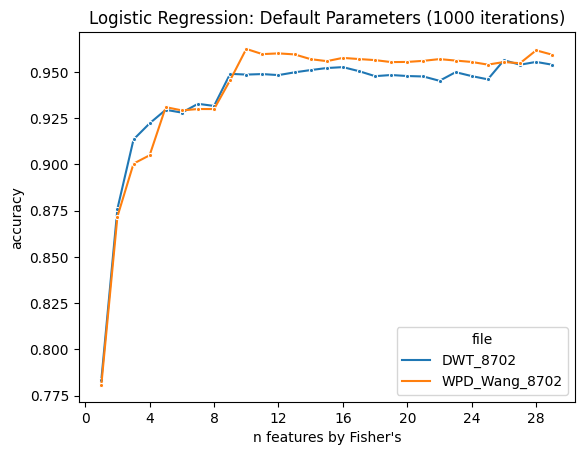

In [195]:
#full set of features, default parameters  for logistic regression
acc_metrics, pl = accuracy_plot(files = ['DWT_8702', 'WPD_Wang_8702'], #files = ['DWT_4302', 'DWT_8702', 'WPD_Wang_4302', 'WPD_Wang_8702'], 
                                default=True, n_features=29, n_iter=1000)

DWT_8702 in progress


/Users/jhbyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.78541667        nan 0.78921569        nan        nan        nan
        nan 0.42230392 0.78946078 0.78921569 0.78921569 0.78946078
 0.78737745        nan        nan 0.78921569 0.78946078        nan
 0.78946078 0.78921569 0.78333333        nan 0.78921569        nan
 0.78333333        nan        nan        nan 0.78921569 0.38676471
 0.78946078        nan 0.78921569 0.38676471        nan        nan
 0.38676471 0.78946078 0.78921569        nan        nan        nan
 0.77928922 0.78946078 0.78946078        nan        nan        nan
        nan        nan 0.78946078        nan 0.78517157 0.38676471
        nan        nan 0.78921569        nan        nan        nan
        nan        nan        nan        nan 0.78737745        nan
 0.78921569        nan        nan 0.78

WPD_Wang_8702 in progress


/Users/jhbyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.77745098 0.76188725        nan        nan
 0.36323529        nan        nan        nan 0.76188725 0.36323529
 0.77745098        nan 0.79338235        nan        nan        nan
        nan        nan 0.78946078        nan 0.77745098        nan
 0.79338235 0.79338235        nan        nan 0.79338235 0.77745098
 0.79338235 0.77941176 0.36323529 0.75980392        nan 0.77745098
        nan        nan 0.78333333        nan 0.36323529        nan
 0.78541667        nan 0.76580882 0.77745098        nan 0.78333333
 0.79338235 0.77941176 0.77745098        nan        nan        nan
        nan        nan 0.77745098        nan        nan        nan
        nan        nan 0.77745098        nan 0.36323529        nan
 0.79338235        nan 0.36323529 0.79338235 0.78946078        nan
        nan 0.79338235        nan     

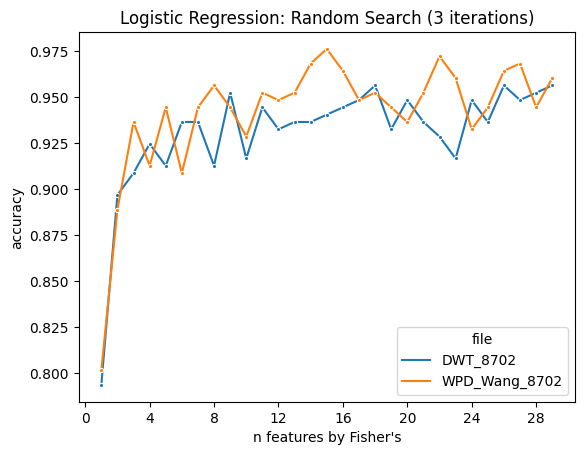

In [197]:
#full set of features, grid search for logistic regression
acc_metrics, pl = accuracy_plot(files = ['DWT_8702', 'WPD_Wang_8702'], 
                                default=False, n_features=29, n_iter=3)

In [194]:
acc_metrics[acc_metrics['n_features'] == 5]

,file,n_features,mean,stdev
4,DWT_4302,5,0.828788,0.053948
33,DWT_8702,5,0.927381,0.019802
62,WPD_Wang_4302,5,0.756061,0.044861
91,WPD_Wang_8702,5,0.933333,0.031845


## Scratchpad:

In [56]:
files = ['DWT_4302', 'DWT_8702', 'WPD_Wang_4302', 'WPD_Wang_8702']
acc_metrics = {} #empty dictionary to store accuracy metrics

for i, file in enumerate(files):
    file_path = 'data/slope_chosenlevels_' + files[i] + '.csv'
    print(file_path)

    lrc = log_reg_class(dir = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-detection', 
                    file_path = file_path) #initialize class

    for j in range(1, 30): #range of fisher's criterion values / # of features
        lrc.fishers(top_n=j)
        n_features, eval_metrics_df = lrc.log_reg(n_iter=100)
        acc = eval_metrics_df['accuracy']
        mean = statistics.mean(acc)
        stdev = statistics.stdev(acc)

        acc_metrics[str(i)+str(j)] = list([file, n_features, mean, stdev]) #store list in dictionary

acc_metrics = pd.DataFrame.from_dict(acc_metrics).T
acc_metrics.columns = ['file', 'n_features', 'mean', 'stdev']
acc_metrics = acc_metrics.reset_index(drop=True)
print(acc_metrics)

data/slope_chosenlevels_DWT_4302.csv
data/slope_chosenlevels_DWT_8702.csv
data/slope_chosenlevels_WPD_Wang_4302.csv
data/slope_chosenlevels_WPD_Wang_8702.csv
              file n_features      mean     stdev
0         DWT_4302          1  0.768636  0.042955
1         DWT_4302          2  0.784848  0.043071
2         DWT_4302          3  0.785606  0.040483
3         DWT_4302          4  0.815303  0.042621
4         DWT_4302          5  0.815606  0.043074
..             ...        ...       ...       ...
111  WPD_Wang_8702         25  0.955833   0.01728
112  WPD_Wang_8702         26     0.955  0.017386
113  WPD_Wang_8702         27  0.955119  0.017161
114  WPD_Wang_8702         28  0.961071  0.016217
115  WPD_Wang_8702         29  0.962262  0.018846

[116 rows x 4 columns]


[Text(0.5, 1.0, 'Logistic Regression: Default Parameters'),
 Text(0.5, 0, "n features by Fisher's"),
 Text(0, 0.5, 'accuracy')]

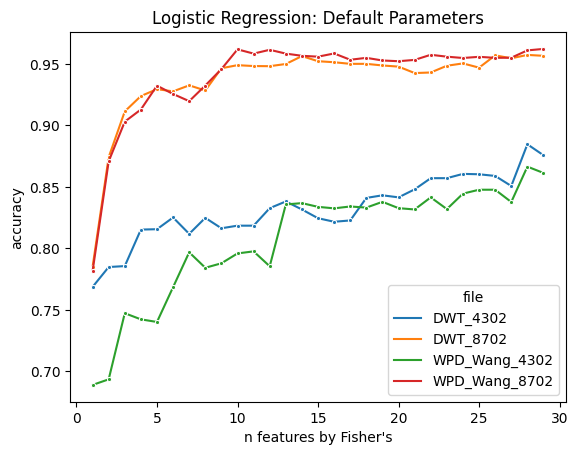

In [87]:
pl = sns.lineplot(data=acc_metrics, x='n_features', y='mean', hue='file', marker='.')
#acc_metrics['upper'] = acc_metrics['mean'] + (acc_metrics['stdev'] / 2)
#acc_metrics['lower'] = acc_metrics['mean'] - (acc_metrics['stdev'] / 2)
#pl.fill_between(acc_metrics.n_features, acc_metrics.upper, acc_metrics.lower)

pl.set(title='Logistic Regression: Default Parameters', xlabel="n features by Fisher's", ylabel='accuracy')

In [ ]:
#accuracy plot
plt.plot(cp.index, cp['accuracy'])
plt.xlabel('Sampling Iteration')
plt.ylabel('Accuracy')
plt.axhline(y = statistics.mean(cp['accuracy']), color = 'black', linestyle = '--')

In [117]:
files = ['DWT_8702', 'WPD_Wang_8702']
acc_metrics_rs = {} #empty dictionary to store accuracy metrics random search

for i, file in enumerate(files):
    file_path = 'data/slope_chosenlevels_' + files[i] + '.csv'
    print(file_path)

    lrc = log_reg_class(dir = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-detection', 
                    file_path = file_path) #initialize class

    for j in range(1, 30): #range of fisher's criterion values / # of features
        lrc.fishers(top_n=j)
        n_features, eval_metrics_df = lrc.log_reg(n_iter=100)
        acc = eval_metrics_df['accuracy']
        mean = statistics.mean(acc)
        stdev = statistics.stdev(acc)

        acc_metrics_rs[str(i)+str(j)] = list([file, n_features, mean, stdev]) #store list in dictionary

acc_metrics_rs = pd.DataFrame.from_dict(acc_metrics_rs).T
acc_metrics_rs.columns = ['file', 'n_features', 'mean', 'stdev']
acc_metrics_rs = acc_metrics_rs.reset_index(drop=True)
print(acc_metrics_rs)

data/slope_chosenlevels_DWT_8702.csv
data/slope_chosenlevels_WPD_Wang_8702.csv
             file n_features      mean     stdev
0        DWT_8702          1     0.785  0.035284
1        DWT_8702          2  0.877024   0.02965
2        DWT_8702          3  0.912738  0.027234
3        DWT_8702          4  0.926786  0.025062
4        DWT_8702          5   0.93131  0.021124
5        DWT_8702          6   0.92631   0.01897
6        DWT_8702          7  0.933095  0.023001
7        DWT_8702          8  0.934881  0.025575
8        DWT_8702          9  0.950714  0.021405
9        DWT_8702         10  0.950476  0.018745
10       DWT_8702         11  0.949286  0.020207
11       DWT_8702         12  0.948095  0.020621
12       DWT_8702         13  0.948452  0.020865
13       DWT_8702         14  0.949405  0.018565
14       DWT_8702         15  0.954405  0.019518
15       DWT_8702         16  0.951905  0.020087
16       DWT_8702         17  0.946905  0.022283
17       DWT_8702         18  0.949048 

[Text(0.5, 1.0, 'Logistic Regression: Random Search (n_iters=100)'),
 Text(0.5, 0, "n features by Fisher's"),
 Text(0, 0.5, 'accuracy')]

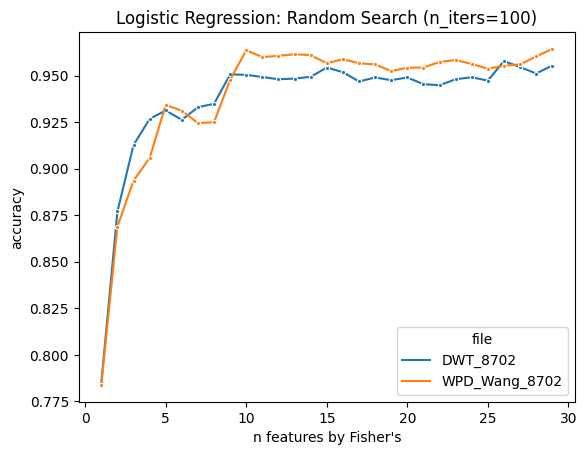

In [120]:
pl = sns.lineplot(data=acc_metrics_rs, x='n_features', y='mean', hue='file', marker='.')

pl.set(title='Logistic Regression: Random Search (n_iters=100)', xlabel="n features by Fisher's", ylabel='accuracy')

significance of features, dixon's google scholar parkinson's paper
confidence intervals for parameters across repetitions

In [16]:
class fishers_log_reg:
    def fishers(df, top_n=5): #default 5 windows with highest Fisher's criterion values

        col_names = df.columns 
        df_long = pd.melt(df, id_vars=['state'], value_vars=col_names)
        df_mean = df_long.groupby(['state', 'variable'], as_index=False).mean() #mean for each window, grouped by state (0 or 1)
        df_stdev = df_long.groupby(['state', 'variable'], as_index=False).std() #stdev for each window, grouped by state (0 or 1)

        df_summary = pd.merge(df_mean, df_stdev, how='inner', on=['state', 'variable']) #join mean and stdev
        df_summary.columns = ['state', 'slope', 'mean', 'stdev'] #rename columns

        df_summary = pd.pivot(df_summary, columns='state', index='slope', values=['mean', 'stdev']) #pivot wider on state
        df_summary.columns = ['mean_0', 'mean_1', 'stdev_0', 'stdev_1'] #0 for controls, 1 for cases
        df_summary['fishers'] = (df_summary['mean_1'] - df_summary['mean_0'])**2 / (df_summary['stdev_1']**2 + df_summary['stdev_0']**2) #calculate Fisher's criterion for each window
        df_summary = df_summary.sort_values(by='fishers', ascending=False)
        df_summary.reset_index(inplace=True)

        sel_windows = df_summary.head(n=top_n)['slope'].to_list() #list of n windows with highest Fisher's criterion values, default = 5
        sel_windows.append('state') #add 'state' to list
        df = df[sel_windows] #subset original dataframe with n windows with highest Fisher's criterion values + state

        return df


    def log_reg(df, n_iter=1000):

        df = df
        x = df.loc[:, df.columns != 'state'] #features
        y = df.loc[:, df.columns == 'state'] #supervisor

        eval_metrics = { #empty dictionary to store classification report
            '0_precision': [],
            '0_recall': [],
            '0_f1-score': [],
            '0_support': [],

            '1_precision': [],
            '1_recall': [],
            '1_f1-score': [],
            '1_support': [],
            
            'accuracy': [],
        }

        for i in range(n_iter): 

            x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

            scaler = StandardScaler()    
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

            log_reg_model = LogisticRegression(class_weight='balanced') #default 
            log_reg_model.fit(x_train, y_train.values.ravel())
            
            y_pred = log_reg_model.predict(x_test)
            report = classification_report(y_test, y_pred, output_dict=True)

            eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
            eval_metrics['0_recall'].append(report['0']['recall'])
            eval_metrics['0_f1-score'].append(report['0']['f1-score'])
            eval_metrics['0_support'].append(report['0']['support'])

            eval_metrics['1_precision'].append(report['1']['precision'])
            eval_metrics['1_recall'].append(report['1']['recall'])
            eval_metrics['1_f1-score'].append(report['1']['f1-score'])
            eval_metrics['1_support'].append(report['1']['support'])

            eval_metrics['accuracy'].append(report['accuracy'])

        eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

        return eval_metrics_df


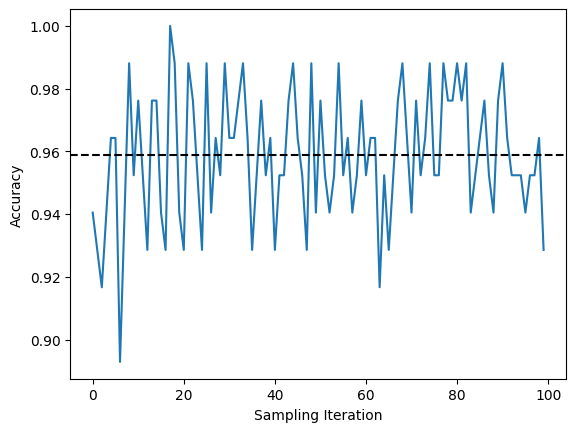

In [37]:
#accuracy plot
plt.plot(cp.index, cp['accuracy'])
plt.xlabel('Sampling Iteration')
plt.ylabel('Accuracy')
plt.axhline(y = statistics.mean(cp['accuracy']), color = 'black', linestyle = '--')

In [39]:
#classification performance 
cp1 = fishers_log_reg.log_reg(wp8, n_iter=10)
cp2 = fishers_log_reg.log_reg(wp8, n_iter=10)
cp3 = fishers_log_reg.log_reg(wp8, n_iter=10)

In [ ]:
dfs = {[cp1, cp2, cp3]}



In [273]:
def test_fx(tuning=['none', 'random_search', 'forward', 'backward']):
    print(tuning)

In [272]:
def log_reg(df, n_iter=1000, tuning=['none', 'random_search', 'forward', 'backward']): #default 1k iterations

    df = df
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()
        log_reg_model = LogisticRegression(class_weight='balanced') #default 

        if(fishers==False): #default logistic regression params
            scaler.fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)

            log_reg_model.fit(x_train, y_train.values.ravel())
            y_pred = log_reg_model.predict(x_test)
        
        else: #fishers=True, random search through grid
            param_grid = {
            'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'None'],
            'log_reg__C': loguniform(1e-5, 100)
            }
            
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)

            pipeline = Pipeline(steps=[("scaler", scaler), ("log_reg", log_reg_model)])
            search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv)

            result = search.fit(x_train, y_train.values.ravel())
            y_pred = result.predict(x_test)

        report = classification_report(y_test, y_pred, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [268]:
log_reg(wp8, n_iter=100)

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy
0,0.920000,0.920000,0.920000,25,0.966102,0.966102,0.966102,59,0.952381
1,1.000000,0.941176,0.969697,34,0.961538,1.000000,0.980392,50,0.976190
2,0.935484,0.906250,0.920635,32,0.943396,0.961538,0.952381,52,0.940476
3,0.968750,0.968750,0.968750,32,0.980769,0.980769,0.980769,52,0.976190
4,0.870968,0.931034,0.900000,29,0.962264,0.927273,0.944444,55,0.928571
5,1.000000,0.909091,0.952381,33,0.944444,1.000000,0.971429,51,0.964286
6,0.972222,0.972222,0.972222,36,0.979167,0.979167,0.979167,48,0.976190
7,1.000000,0.968750,0.984127,32,0.981132,1.000000,0.990476,52,0.988095
8,0.903226,0.933333,0.918033,30,0.962264,0.944444,0.953271,54,0.940476
9,1.000000,0.812500,0.896552,32,0.896552,1.000000,0.945455,52,0.928571


#### 1A. Wavelet Packet / Wang, 8-7-02 data (wp8)

In [116]:
log_reg(df = wp8, n_iter = 10000)

accuracy       0.960380
specificity    0.955543
sensitivity    0.963284
dtype: float64

#### 1B. Discrete Wavelet Transform, 8-7-02 data (dwt8)

In [118]:
log_reg(df = dwt8, n_iter = 10000)

accuracy       0.954846
specificity    0.952806
sensitivity    0.956179
dtype: float64

1. train/test split
2. parameter tuning (training set)
3. take parameters, fit logistic regression model
4. test data for performance

In [147]:
log_reg_random_search(df = wp8, n_iter=1)

accuracy       0.940476
specificity    0.911765
sensitivity    0.960000
dtype: float64

In [148]:
log_reg_random_search(df = wp8, n_iter=1)

accuracy       0.988095
specificity    0.969697
sensitivity    1.000000
dtype: float64

#### 2A. Wavelet Packet / Wang, 8-7-02 data (wp8)

In [132]:
log_reg_random_search(df = wp8, n_iter=100)

accuracy       0.957976
specificity    0.961615
sensitivity    0.956103
dtype: float64

#### 2B. Discrete Wavelet Transform, 8-7-02 data (dwt8)

In [133]:
log_reg_random_search(df = dwt8, n_iter=100)

accuracy       0.948929
specificity    0.946467
sensitivity    0.951120
dtype: float64

## Fisher's

In [139]:
def fishers(df, top_n=5):
    col_names = df.columns
    df_long = pd.melt(df, id_vars=['state'], value_vars=col_names)
    df_mean = df_long.groupby(['state', 'variable'], as_index=False).mean() #mean for each window
    df_stdev = df_long.groupby(['state', 'variable'], as_index=False).std() #stdev for each window

    df_summary = pd.merge(df_mean, df_stdev, how='inner', on=['state', 'variable']) #join mean and stdev
    df_summary.columns = ['state', 'slope', 'mean', 'stdev'] #rename columns
    df_summary = pd.pivot(df_summary, columns='state', index='slope', values=['mean', 'stdev']) #pivot wider on state
    df_summary.columns = ['mean_0', 'mean_1', 'stdev_0', 'stdev_1'] #0 for controls, 1 for cases
    df_summary['fishers'] = (df_summary['mean_1'] - df_summary['mean_0'])**2 / (df_summary['stdev_1']**2 + df_summary['stdev_0']**2) #calculate Fisher's criterion for each window
    df_summary = df_summary.sort_values(by='fishers', ascending=False)
    df_summary.reset_index(inplace=True)
    five_windows = df_summary.head(n=5)['slope'].to_list() #windows with 5 highest Fisher's criterion values
    five_windows.append('state') #add state column
    df_five = df[five_windows] #subset original dataframe with five windows with highest Fisher's criterion values

    return df_five    

In [142]:
wp8_fishers = fishers(df = wp8, top_n=5)
dwt8_fishers = fishers(df = dwt8, top_n=5)

In [143]:
#Repeated Sampling Function
print(log_reg(df = wp8, n_iter = 10000))
print(log_reg(df = dwt8, n_iter = 10000))

accuracy       0.960474
specificity    0.955562
sensitivity    0.963315
dtype: float64
accuracy       0.955301
specificity    0.953615
sensitivity    0.956374
dtype: float64


In [145]:
#Repeated Sampling Function with Fisher's Criterion Filter
print(log_reg(df = wp8_fishers, n_iter = 10000))
print(log_reg(df = dwt8_fishers, n_iter = 10000))

accuracy       0.931142
specificity    0.935844
sensitivity    0.928546
dtype: float64
accuracy       0.927326
specificity    0.942333
sensitivity    0.918857
dtype: float64


In [144]:
#Logistic Regression with Random Search
print(log_reg_random_search(df = wp8, n_iter=100))
print(log_reg_random_search(df = dwt8, n_iter=100))

accuracy       0.95619
specificity    0.95405
sensitivity    0.95712
dtype: float64
accuracy       0.950476
specificity    0.955320
sensitivity    0.948092
dtype: float64


In [146]:
#Logistic Regression with Random Search with Fisher's Criterion Filter
print(log_reg_random_search(df = wp8_fishers, n_iter=100))
print(log_reg_random_search(df = dwt8_fishers, n_iter=100))

accuracy       0.954048
specificity    0.954259
sensitivity    0.954059
dtype: float64
accuracy       0.953214
specificity    0.959635
sensitivity    0.949955
dtype: float64
